# Methods
- Data collection procedure, sample size, and sampling design
- Data cleaning and data preprocessing
- Data analysis
- Data Visualization
- Results and discussion



In [154]:
#important libraries

#DataFrames and Math
import pandas as pd
import numpy as np
from collections import Counter

#Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
plt.style.use('fivethirtyeight')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

#Stopwords
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

#Scraper
from google_play_scraper import app
from google_play_scraper import Sort, reviews_all

## Data collection procedure, sample size, and sampling design

### Google_play_scraper
provides APIs to easily crawl the Google Play Store for Python without any external dependencies!
<br>
Documentation link https://pypi.org/project/google-play-scraper/

In [59]:
result = reviews_all(
    'com.netmarble.marvelfr',
    sleep_milliseconds=0,
    lang='en', 
    country='us',
    sort=Sort.MOST_RELEVANT,
    #filter_score_with=0 
)

In [60]:
len(result)

16363

In [61]:
df = pd.DataFrame(result)

In [62]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,gp:AOqpTOHR-Cc9HA3JQvqJG6nXi1fvJ0lWSJy83cbmgZL...,Victor Keys,https://play-lh.googleusercontent.com/a/AATXAJ...,"Amazing game, its similar to other games but s...",5,83,1.1.5,2021-09-01 06:20:25,None,NaT
1,gp:AOqpTOGKGTq2oKNpV3bzucM-Dpyo8tDhtQhygrwgDwT...,David Nix,https://play-lh.googleusercontent.com/a-/AOh14...,The game is ok. My complaints are mostly issue...,3,74,1.1.5,2021-08-31 06:09:37,"Hello, David, we are sorry to hear about your ...",2021-09-03 10:20:54
2,gp:AOqpTOFFDp5fSNdYcsbwTT0bgK1wtV5q8V_r0RAC9tS...,dawg,https://play-lh.googleusercontent.com/a-/AOh14...,"This game seems amazing, I've heard so much go...",3,69,1.1.5,2021-09-02 10:29:40,"Hello, Dawg. We’re sorry for the inconvenience...",2021-09-03 16:09:41
3,gp:AOqpTOE9gM4Ze5RuyuYjFIYx2u23vBS-JExK6CPQKco...,toxic shock,https://play-lh.googleusercontent.com/a-/AOh14...,The game is really good but it needs more side...,4,16,1.1.5,2021-09-01 19:53:26,None,NaT
4,gp:AOqpTOE5Ez7aNtKhZHbrslorbGz3p_uEOtVqwCVeFkz...,Real_Quench,https://play-lh.googleusercontent.com/a-/AOh14...,Would like to see it compatible to play with a...,3,4,1.1.5,2021-09-02 01:43:20,"Hello, Real_Quench. Thank you for your honest ...",2021-09-01 15:48:02


In [90]:
score_counts = df.groupby(['score']).size()
score_counts

score
1    3720
2    1012
3    1262
4    1729
5    8640
dtype: int64

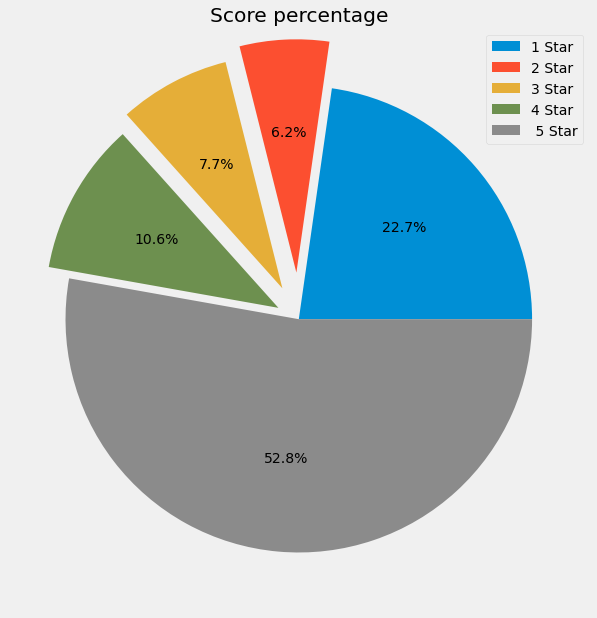

In [114]:
plt.figure(figsize=(10, 10))
plt.pie(score_counts, explode = (0, 0.20, 0.15, 0.1, 0), autopct='%1.1f%%')
plt.legend(['1 Star', '2 Star', '3 Star', '4 Star', ' 5 Star'])
plt.title('Score percentage')
plt.show()

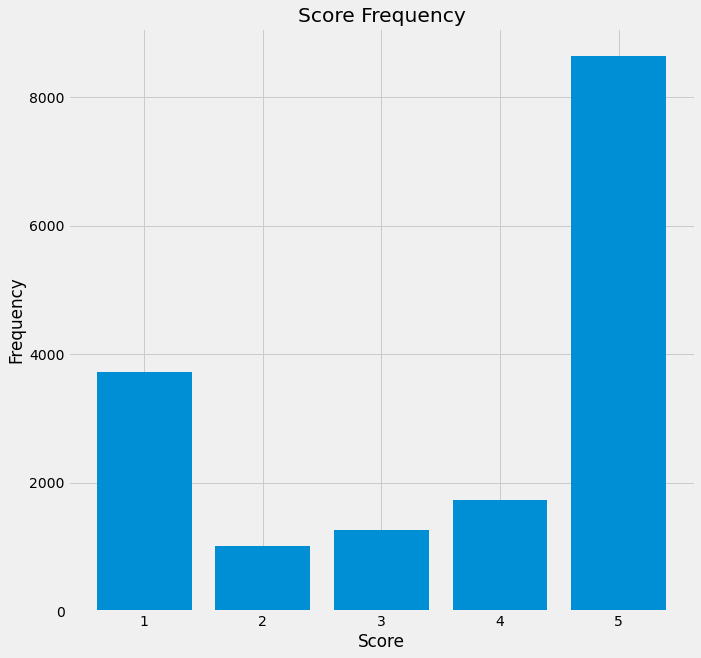

In [117]:
plt.figure(figsize=(10, 10))
plt.bar(score_counts.index, score_counts)

plt.ylabel('Frequency')
plt.xlabel('Score')
plt.title('Score Frequency')

plt.show()

## Data cleaning and data preprocessing

In [91]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

reviewId - 0%
userName - 0%
userImage - 0%
content - 0%
score - 0%
thumbsUpCount - 0%
reviewCreatedVersion - 36%
at - 0%
replyContent - 62%
repliedAt - 62%


In [95]:
df.dropna(thresh=df.shape[0]*0.9, how='all', axis=1, inplace = True)

In [97]:
df.drop(['reviewId', 'userImage', 'at'], axis = 1, inplace = True)

In [98]:
df.head()

,userName,content,score,thumbsUpCount
0,Victor Keys,"Amazing game, its similar to other games but s...",5,83
1,David Nix,The game is ok. My complaints are mostly issue...,3,74
2,dawg,"This game seems amazing, I've heard so much go...",3,69
3,toxic shock,The game is really good but it needs more side...,4,16
4,Real_Quench,Would like to see it compatible to play with a...,3,4


In [118]:
def clean_text(text):
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if not t in stopwords] #remove stopwords
    tokens = [t for t in tokens if t.isalnum()] #remove punctuation
    text_clean = " ".join(tokens)
    
    return text_clean

In [119]:
df['Clean content'] = [clean_text(text) for text in df.content]

In [120]:
df.head()

,userName,content,score,thumbsUpCount,Clean content
0,Victor Keys,"Amazing game, its similar to other games but s...",5,83,Amazing game similar games seems thought The t...
1,David Nix,The game is ok. My complaints are mostly issue...,3,74,The game My complaints mostly issues dialogue ...
2,dawg,"This game seems amazing, I've heard so much go...",3,69,This game seems amazing I heard much good stuf...
3,toxic shock,The game is really good but it needs more side...,4,16,The game really good needs side missions chara...
4,Real_Quench,Would like to see it compatible to play with a...,3,4,Would like see compatible play mobile gaming c...


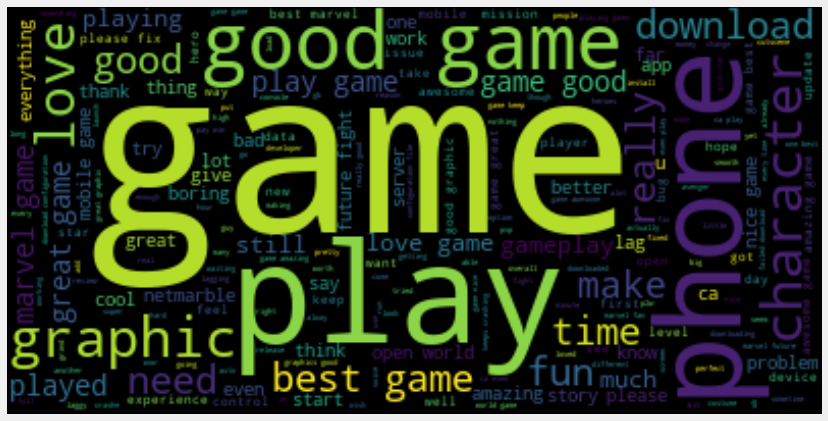

In [134]:
text = df['Clean content'].tolist() 

# join the list and lowercase all the words
text = ' '.join(text).lower()

#create the wordcloud object
wordcloud = WordCloud(stopwords = STOPWORDS,
                      collocations=True).generate(text)

plt.figure(figsize=(13, 10))
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

In [139]:
# assign reviews with score > 3 as positive sentiment
# score < 3 negative sentiment
# remove score = 3

df = df[df['score'] != 3]
df['sentiment'] = df['score'].apply(lambda rating : 'Positive' if rating > 3 else 'Negative')

<ipython-input-139-6d1fc5c04000>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [164]:
df.head()

,userName,content,score,thumbsUpCount,Clean content,sentiment
0,Victor Keys,"Amazing game, its similar to other games but s...",5,83,Amazing game similar games seems thought The t...,Positive
3,toxic shock,The game is really good but it needs more side...,4,16,The game really good needs side missions chara...,Positive
5,Zealous,I have enjoyed this game a lot and I feel that...,4,6,I enjoyed game lot I feel one best story mode ...,Positive
7,andrea hudgins,"The story is decent, some pretty humorous dial...",2,13,The story decent pretty humorous dialog certai...,Negative
8,Eric Cartman,"Great gameplay, Great graphics, and Great diff...",5,0,Great gameplay Great graphics Great difficulty...,Positive


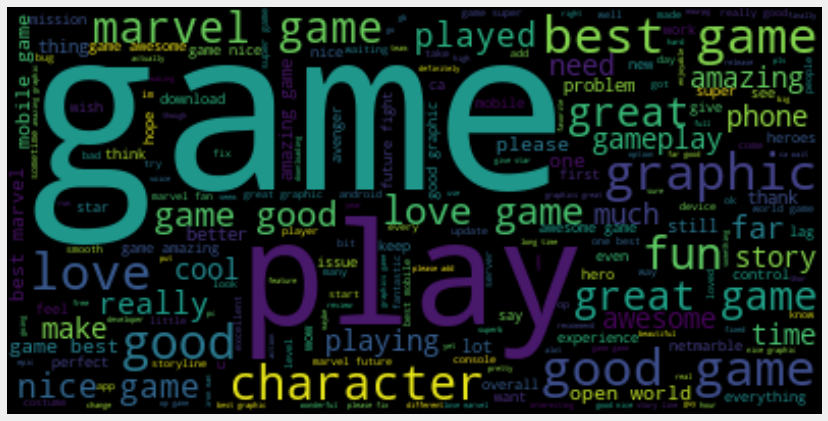

In [169]:
text = df[df.sentiment == 'Positive']['Clean content'].tolist() 

# join the list and lowercase all the words
text = ' '.join(text).lower()

#create the wordcloud object
wordcloud = WordCloud(stopwords = STOPWORDS,
                      collocations=True).generate(text)

plt.figure(figsize=(13, 10))
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

In [170]:
counter_obj = Counter(text.split())
top10 = pd.DataFrame(counter_obj.most_common(n=10), columns = ['Words', 'Frequency'])
top10.index += 1
top10

,Words,Frequency
1,game,7835
2,i,4074
3,good,2051
4,best,1471
5,marvel,1202
6,like,1195
7,graphics,1166
8,love,1086
9,great,1051
10,play,890


In [190]:
top10 = pd.DataFrame(df[df.sentiment == 'Positive'].content)
top10.reset_index(inplace = True)
top10.drop('index', axis = 1, inplace = True)
top10.index += 1
top10.head(10)

,content
1,"Amazing game, its similar to other games but s..."
2,The game is really good but it needs more side...
3,I have enjoyed this game a lot and I feel that...
4,"Great gameplay, Great graphics, and Great diff..."
5,"This is a fantastic marvel RPG, with a good pl..."
6,I've enjoyed playing so far. It's pretty grind...
7,"Super fun! Doesn't seem too pay to win, level ..."
8,Finally! What we have been begging for. They h...
9,Just gotten into it and am enjoying it so far....
10,"So the game is good, the graphics are great, t..."


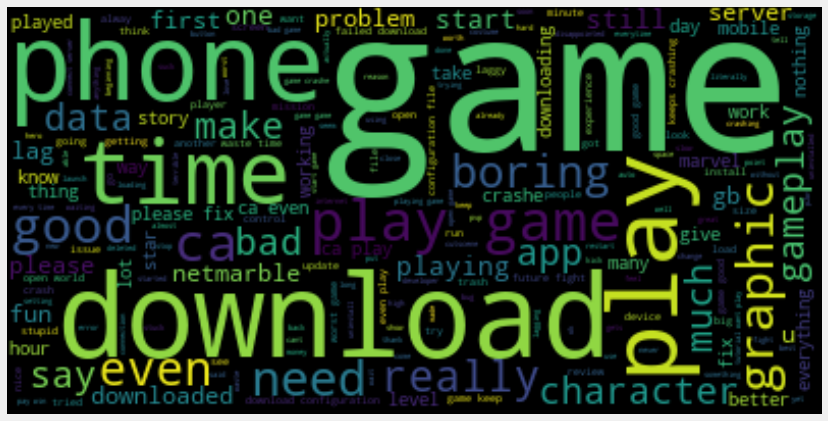

In [191]:
text = df[df.sentiment == 'Negative']['Clean content'].tolist() 

# join the list and lowercase all the words
text = ' '.join(text).lower()

#create the wordcloud object
wordcloud = WordCloud(stopwords = STOPWORDS,
                      collocations=True).generate(text)

plt.figure(figsize=(13, 10))
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

In [192]:
counter_obj = Counter(text.split())
top10 = pd.DataFrame(counter_obj.most_common(n=10), columns = ['Words', 'Frequency'])
top10.index += 1
top10

,Words,Frequency
1,game,4029
2,i,3123
3,play,1151
4,download,754
5,even,610
6,it,569
7,ca,504
8,the,497
9,like,496
10,phone,491


In [193]:
top10 = pd.DataFrame(df[df.sentiment == 'Negative'].content)
top10.reset_index(inplace = True)
top10.drop('index', axis = 1, inplace = True)
top10.index += 1
top10.head(10)

,content
1,"The story is decent, some pretty humorous dial..."
2,I tried to play this for three days now and I ...
3,There's 2 big problem in this game. 1) auto-pl...
4,"The game is very fun and, for me, fills the ga..."
5,As much as I like the gear and appearance cust...
6,"Lag problem, game keeps freezing, I have to ke..."
7,It should give me action to the tip of my fing...
8,The lag is unreal. 300 to 600 ping even with h...
9,It's basically the old Marvel Heroes (from Gaz...
10,Everything was going well and really was enjoy...
